End to end machine learning workflow to predict mortality within 180 days of last visit

This is step 5

We will train our model

# Import Packages and Data

In [1]:
# Package Import

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


from collections import Counter
#from imblearn.over_sampling import SMOTE
from numpy import where


from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

/Users/zac/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = pd.read_csv('output/step_4_train_demographics.csv')

In [3]:
data.head(5)

,person_id,outcome,age_Charlson_index,gender_source_value,ethnicity_source_value,age_last_visit,0.0,196620.0,196628.0,196645.0,...,196461.0,196464.0,196468.0,196469.0,196471.0,196476.0,40304526.0,196523.0,4161462.0,4063171.0
0,138730,1,3,1,1,28.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,127727,1,6,1,2,65.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,46210,1,2,1,3,69.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10249,1,4,2,2,80.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,78014,1,3,1,1,79.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Attempt 1

Try all features

In [4]:
# split split the outcome 

outcome = data['outcome']
data = data.iloc[:,2:]

In [5]:
# Split into train and test(validation) groups
X_train, X_test, y_train, y_test = train_test_split(data, outcome, test_size=.2)

In [6]:
hist = []
roc = []
for i in range(1):
    model = XGBClassifier(n_estimators=50,max_depth=5)
    #model = LogisticRegression(solver='lbfgs',max_iter = 10000)
    model.fit(X_train, y_train)
    preds = list(model.predict(X_test))
    y_test = list(y_test)
    w=0
    for i in range(len(preds)):
        if(preds[i]==y_test[i]):
            w=w+1
    hist.append(w/len(preds))
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    lr_auc = roc_auc_score(y_test, lr_probs)
    roc.append(lr_auc)



print(sum(hist)/len(hist))
print(sum(roc)/len(roc))

/Users/zac/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/zac/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:25:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9455
0.5346498867159263


Good accuracy but because of the imbalanced data, but the roc auc score could possibly be improved

# Attempt 2

Lets try to reduce dimensions of the problem by selecting certain features

In [8]:
sel = VarianceThreshold(threshold=(.95*(1-.95)))
var = sel.fit(X_train)

var_xtrain = var.transform(X_train)
var_xtest = var.transform(X_test)

In [9]:
hist = []
roc = []
for i in range(1):
    model = XGBClassifier(n_estimators=50,max_depth=5)
    #model = LogisticRegression(solver='lbfgs',max_iter = 10000)
    model.fit(var_xtrain, y_train)
    preds = list(model.predict(var_xtest))
    y_test = list(y_test)
    w=0
    for i in range(len(preds)):
        if(preds[i]==y_test[i]):
            w=w+1
    hist.append(w/len(preds))
    lr_probs = model.predict_proba(var_xtest)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    lr_auc = roc_auc_score(y_test, lr_probs)
    roc.append(lr_auc)



print(sum(hist)/len(hist))
print(sum(roc)/len(roc))

/Users/zac/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:26:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9455
0.5367312086707193


That didn't do anything

# Attempt 3

Try under sampling data

In [15]:
under_sample_data = data.head(1000)
under_sample_outcome = outcome[:1000]

In [16]:
# Split into train and test(validation) groups
X_train, X_test, y_train, y_test = train_test_split(data, outcome, test_size=.2)

In [21]:
hist = []
roc = []
for i in range(1):
    model = XGBClassifier(n_estimators=50,max_depth=5)
    #model = LogisticRegression(solver='lbfgs',max_iter = 10000)
    model.fit(X_train, y_train)
    preds = list(model.predict(X_test))
    y_test = list(y_test)
    w=0
    for i in range(len(preds)):
        if(preds[i]==y_test[i]):
            w=w+1
    hist.append(w/len(preds))
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    lr_auc = roc_auc_score(y_test, lr_probs)
    roc.append(lr_auc)



print(sum(hist)/len(hist))
print(sum(roc)/len(roc))

/Users/zac/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/zac/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:32:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9515
0.5548537035933496


It's getting better

# Attempt 4

In [69]:
under_sample_data = data
under_sample_outcome = outcome

In [73]:
# Split into train and test(validation) groups
X_train, X_test, y_train, y_test = train_test_split(data, outcome, test_size=.1)

In [74]:
hist = []
roc = []
for i in range(1):
    model = XGBClassifier(n_estimators=50,max_depth=5)
    #model = LogisticRegression(solver='lbfgs',max_iter = 10000)
    model.fit(X_train, y_train)
    preds = list(model.predict(X_test))
    y_test = list(y_test)
    w=0
    for i in range(len(preds)):
        if(preds[i]==y_test[i]):
            w=w+1
    hist.append(w/len(preds))
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    lr_auc = roc_auc_score(y_test, lr_probs)
    roc.append(lr_auc)



print(sum(hist)/len(hist))
print(sum(roc)/len(roc))

/Users/zac/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/zac/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:42:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.944
0.5655077179176755


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

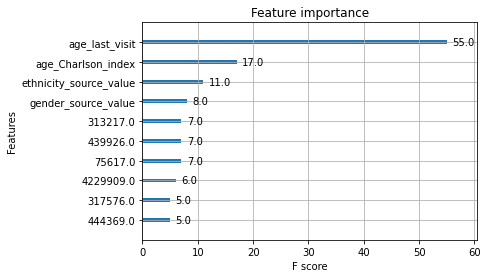

In [75]:
plot_importance(model,max_num_features=10)

# Important features

['age_last_visit','age_Charlson_index','313217.0','439926.0','75617.0','4229909.0','317576.0','444369.0']


In order to reduce dimensions and speed up training time we will only use these features to predict. We do not expect a good model, but it is taking way too long on my computer.